<a href="https://colab.research.google.com/github/Rionzagal/Pi2-Eq139/blob/main/3D_unet_singlechannel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Generate the 3D U-Net model blocks and definitions

In [ ]:
from keras.models import Model
from keras.layers import Input, Conv3D, MaxPooling3D, Conv3DTranspose,\
  BatchNormalization, Activation, Concatenate


def conv_block(input, num_filters):
  x = Conv3D(num_filters, 3, padding="same")(input)
  # x = BatchNormalization()(x)   #Not in the original network.
  x = Activation("relu")(x)

  x = Conv3D(num_filters, 3, padding="same")(x)
  # x = BatchNormalization()(x)  #Not in the original network.
  x = Activation("relu")(x)

  return x

#Encoder block: Conv block followed by maxpooling
def encoder_block(input, num_filters):
  x = conv_block(input, num_filters)
  p = MaxPooling3D((2, 2, 2))(x)
  return x, p

#Decoder block
#skip features gets input from encoder for concatenation
def decoder_block(input, skip_features, num_filters):
  x = Conv3DTranspose(num_filters, (2, 2, 2), strides=2, padding="same")(input)
  x = Concatenate()([x, skip_features])
  x = conv_block(x, num_filters)
  return x

In [ ]:
from keras import backend as K

def dice_coefficient(predictions, targets, smoothing_factor=1e-6):
  predictions = tf.cast(predictions, dtype=tf.float32)
  targets = tf.cast(targets, dtype=tf.float32)

  intersection = K.sum(K.flatten(predictions * targets))
  union = K.sum(K.flatten(predictions)) + K.sum(K.flatten(targets))

  return (2 * intersection + smoothing_factor) / (union + smoothing_factor)


def dice_coefficient_loss(y_true, y_pred):
  return 1 - dice_coefficient(y_true, y_pred)

# Import the relevant data and generate the dataset for the data segmentation

## Loading and visualizing the dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
!unzip "/content/drive/MyDrive/PI2_A5/archive.zip" -d "/content/data"

Archive:  /content/drive/MyDrive/PI2_A5/archive.zip
  inflating: /content/data/MICCAI_BraTS_2019_Data_Training/HGG/BraTS19_2013_10_1/BraTS19_2013_10_1_flair.nii  
  inflating: /content/data/MICCAI_BraTS_2019_Data_Training/HGG/BraTS19_2013_10_1/BraTS19_2013_10_1_seg.nii  
  inflating: /content/data/MICCAI_BraTS_2019_Data_Training/HGG/BraTS19_2013_10_1/BraTS19_2013_10_1_t1.nii  
  inflating: /content/data/MICCAI_BraTS_2019_Data_Training/HGG/BraTS19_2013_10_1/BraTS19_2013_10_1_t1ce.nii  
  inflating: /content/data/MICCAI_BraTS_2019_Data_Training/HGG/BraTS19_2013_10_1/BraTS19_2013_10_1_t2.nii  
  inflating: /content/data/MICCAI_BraTS_2019_Data_Training/HGG/BraTS19_2013_11_1/BraTS19_2013_11_1_flair.nii  
  inflating: /content/data/MICCAI_BraTS_2019_Data_Training/HGG/BraTS19_2013_11_1/BraTS19_2013_11_1_seg.nii  
  inflating: /content/data/MICCAI_BraTS_2019_Data_Training/HGG/BraTS19_2013_11_1/BraTS19_2013_11_1_t1.nii  
  inflating: /content/data/MICCAI_BraTS_2019_Data_Training/HGG/BraTS19_201

In [ ]:
import os
import pandas as pd

file_path = "/content/data/MICCAI_BraTS_2019_Data_Training"
file_mapping = pd.read_csv(
    "/content/data/MICCAI_BraTS_2019_Data_Training/name_mapping.csv"
    )
print(file_mapping.shape)
file_mapping.head()

data_dirs = [os.path.join(file_path, grade, subject) for grade, subject in
             zip(file_mapping.Grade, file_mapping.BraTS_2019_subject_ID)]
os.listdir(data_dirs[0])

(335, 5)


['BraTS19_CBICA_AAB_1_t1.nii',
 'BraTS19_CBICA_AAB_1_seg.nii',
 'BraTS19_CBICA_AAB_1_flair.nii',
 'BraTS19_CBICA_AAB_1_t2.nii',
 'BraTS19_CBICA_AAB_1_t1ce.nii']

Tumor labels: [0. 1. 2. 4.]


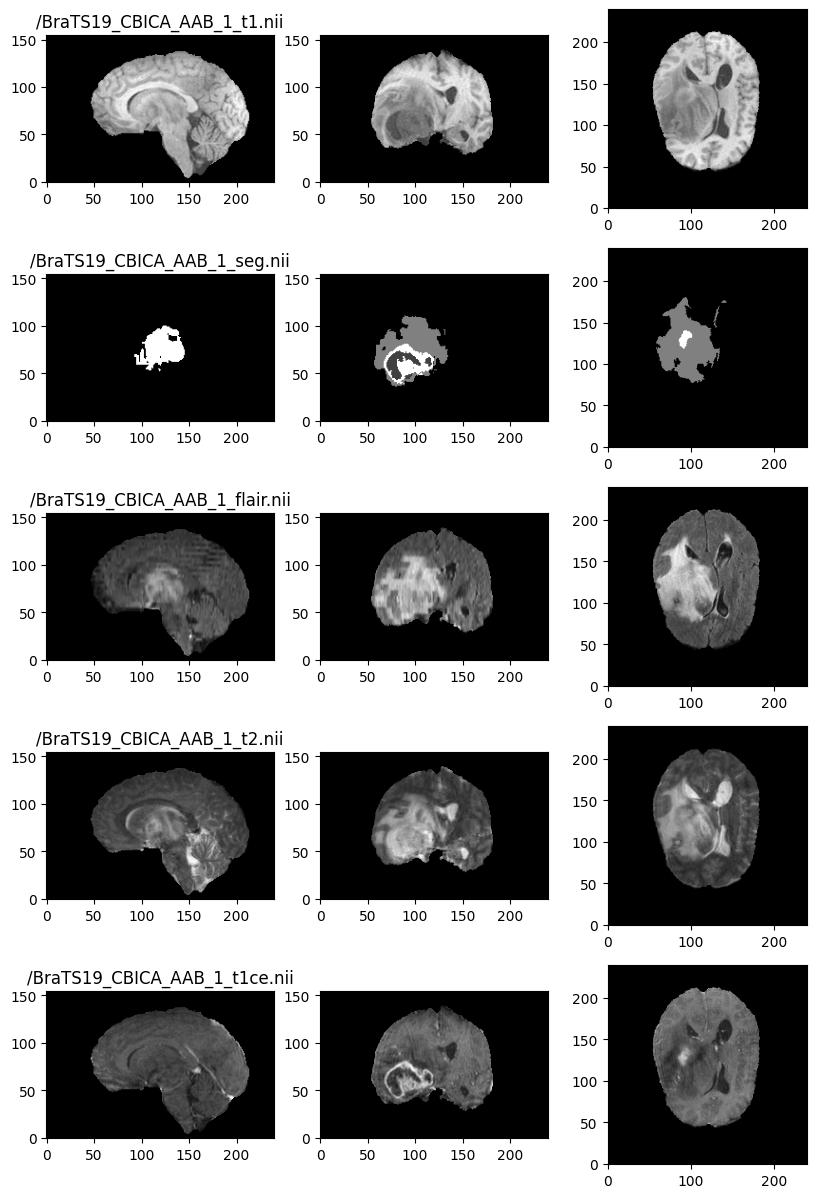

In [ ]:
import numpy as np
import nibabel as nib
import matplotlib as mpl
from matplotlib import pyplot as plt


ex_dir = data_dirs[0]
dir_files = [os.path.join(ex_dir, item) for item in os.listdir(ex_dir)]
fig, axs = plt.subplots(nrows=len(dir_files), ncols=3, figsize=(10, 15))

for n_row, fname in enumerate(dir_files):
  f_data = nib.load(fname)
  img = f_data.get_fdata()

  axs[n_row, 0].set_title(fname.replace(ex_dir, ""))

  axs[n_row, 0].imshow(img[120, ...].T, cmap="gray", origin="lower")
  axs[n_row, 1].imshow(img[:, 120, :].T, cmap="gray", origin="lower")
  axs[n_row, 2].imshow(img[..., 80].T, cmap="gray", origin="lower")

ex_labels = nib.load([item for item in dir_files if "seg.nii" in item][0])\
            .get_fdata()
print("Tumor labels:", np.unique(ex_labels))

In [ ]:
ex_tensor = []
for fname in dir_files:
  if "seg.nii" in fname: continue
  data = nib.load(fname)
  image = np.array(data.get_fdata())
  ex_tensor.append(image)

ex_tensor = np.stack(ex_tensor, axis=-1)
print(ex_tensor.shape)

(240, 240, 155, 4)


## Preprocessing the loaded dataset and creating a fitting tensorflow dataset

In [ ]:
from glob import glob
import tensorflow as tf
from scipy.ndimage import zoom


def read_image(x, dtype=np.float32):
    data = nib.load(x)
    image = np.array(data.get_fdata())
    return image.astype(dtype)


def zoom_image(x, target_shape, **kwargs):
    assert len(x.shape) == len(target_shape)
    zoom_factor = tuple(t_dim / x_dim for x_dim, t_dim
                        in zip(x.shape, target_shape))
    return zoom(x, zoom_factor, **kwargs)

def to_categorical(x, classes):
    mask_shape = list(x.shape)
    mask_shape.append(len(classes))
    mask = np.zeros(tuple(mask_shape), dtype=x.dtype)

    for i, c in enumerate(classes):
      mask_class = (x == c)
      mask[..., i] = mask_class
    return mask


TARGET_SHAPE = (64, 64, 64, 4) # Including channels.

# Get a small sample of the images excluding the segmentation masks.
images = [
    [item for item
     in glob(os.path.join(dir, r"*.nii"))
     if "seg.nii" not in item]
    for dir in data_dirs
    ]
ex_files = images[0]
print([f.replace(file_path, "") for f in ex_files[:]])

# Procedure to create the image with its respective channels.
ex_imgs = []
for fname in ex_files:
  img = read_image(fname)
  img = zoom_image(img, TARGET_SHAPE[:-1])
  ex_imgs.append(img)

ex_tensor = np.stack(ex_imgs, axis=-1)
print(ex_tensor.shape)

# Get a small sample of the segmentation mask for one tumor.
masks = [glob(os.path.join(dir, r"*seg.nii"))[0] for dir in data_dirs]
ex_labels = masks[0]

# Procedure to create the categorical masks for the different segmentation
# classes.
mask = read_image(ex_labels)
mask = zoom_image(mask, TARGET_SHAPE[:-1], order=0)
print(np.unique(mask), mask.shape)

mask = to_categorical(mask, np.unique(mask))
print(np.unique(mask), mask.shape)

['/HGG/BraTS19_CBICA_AAB_1/BraTS19_CBICA_AAB_1_t1.nii', '/HGG/BraTS19_CBICA_AAB_1/BraTS19_CBICA_AAB_1_flair.nii', '/HGG/BraTS19_CBICA_AAB_1/BraTS19_CBICA_AAB_1_t2.nii', '/HGG/BraTS19_CBICA_AAB_1/BraTS19_CBICA_AAB_1_t1ce.nii']
(64, 64, 64, 4)
[0. 1. 2. 4.] (64, 64, 64)
[0. 1.] (64, 64, 64, 4)


In [ ]:
def preprocess(images, masks):
  def f(x, y):
    target_shape = TARGET_SHAPE[:-1]

    # Read all the non-segmentation images from the x argument and resize
    # them.
    for item in x:
      if "flair" not in item.decode(): continue
      item = read_image(item.decode(), dtype=np.float32)
      item = zoom_image(item, target_shape)
      x = item

    # Stack and normalize all the padded non-segmentation images into a 4D
    # array considering the 4 channels.
    x /= x.max()

    # Read and pad the segmentation mask from the y argument.
    y = y.decode()
    y = read_image(y)
    y = zoom_image(y, target_shape, order=0)

    # y = to_categorical(y, [0., 1., 2., 4.]).astype(np.float32)
    y = (y != 0).astype(np.float32)

    return x, y

  image, mask = tf.numpy_function(f, [images, masks],
    [tf.float32, tf.float32])
  image.set_shape(
      [64, 64, 64]
  )
  mask.set_shape(
      [64, 64, 64]
  )
  return image, mask

In [ ]:
batch_size = 5

dataset = tf.data.Dataset.from_tensor_slices((images, masks))
dataset = dataset.shuffle(buffer_size=1000)
dataset = dataset.map(preprocess).batch(batch_size)

num_batches = len(images) // batch_size
train_batches = int(np.floor(num_batches * 0.8))
validation_batches = int(np.floor(num_batches * 0.15))

train_ds = dataset.take(train_batches).prefetch(3)
validation_ds = dataset.skip(train_batches).take(validation_batches)
test_ds = dataset.skip(train_batches + validation_batches)

print(f"Training dataset: {len(train_ds)} batches")
print(f"Validation dataset: {len(validation_ds)} batches")
print(f"Test dataset: {len(test_ds)} batches")

Training dataset: 53 batches
Validation dataset: 10 batches
Test dataset: 4 batches


Images batch shape: (5, 64, 64, 64)


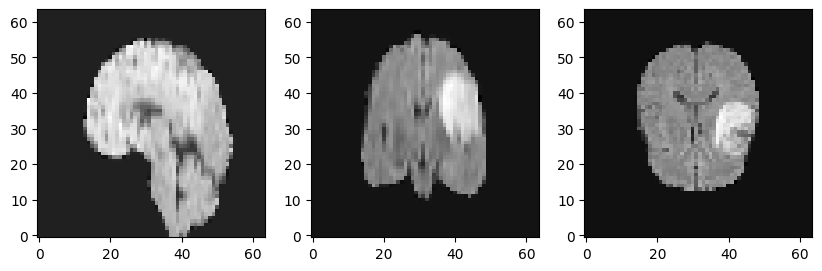

In [ ]:
for batch_images, _ in dataset.take(1):
  print("Images batch shape:", batch_images.numpy().shape)

  ex_vol = batch_images.numpy()[0, ...]
  # Visualize the prefetch data for evaluating its pre-processing.
  fig, axs = plt.subplots(1, 3, figsize=(10, 15))
  axs[0].imshow(ex_vol[32, ...].T, cmap="gray", origin="lower")
  axs[1].imshow(ex_vol[:, 32, :].T, cmap="gray", origin="lower")
  axs[2].imshow(ex_vol[..., 32].T, cmap="gray", origin="lower")

Masks batch shape: (5, 64, 64, 64)


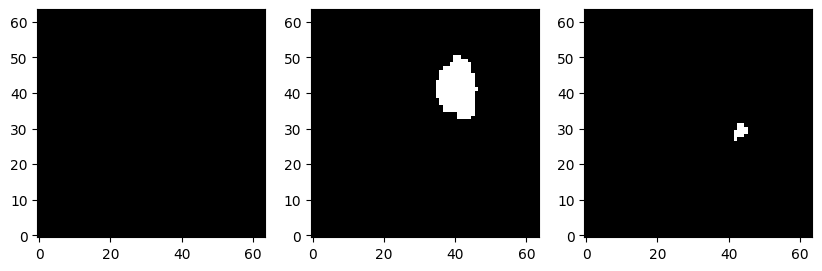

In [ ]:
for _, batch_masks in dataset.take(1):
  print("Masks batch shape:", batch_masks.numpy().shape)

  ex_vol = batch_masks.numpy()[0, ...]
  # Visualize the prefetch data for evaluating its pre-processing.
  fig, axs = plt.subplots(1, 3, figsize=(10, 15))
  axs[0].imshow(ex_vol[32, ...].T, cmap="gray", origin="lower")
  axs[1].imshow(ex_vol[:, 32, :].T, cmap="gray", origin="lower")
  axs[2].imshow(ex_vol[..., 32].T, cmap="gray", origin="lower")

## Adding and visualizing the data augmentation process

In [ ]:
def data_augmentation(x, y):
  return x, y

train_ds = train_ds.map(data_augmentation)

# Build and train the 3D U-Net model

In [ ]:
#Build Unet using the blocks
def build_unet(input_shape, n_classes):
  inputs = Input(input_shape)

  s1, p1 = encoder_block(inputs, 16)
  s2, p2 = encoder_block(p1, 32)
  s3, p3 = encoder_block(p2, 64)

  b1 = conv_block(p3, 128) #Bridge

  d1 = decoder_block(b1, s3, 64)
  d2 = decoder_block(d1, s2, 32)
  d3 = decoder_block(d2, s1, 16)

  if n_classes == 1:  #Binary
    activation = 'sigmoid'
  else:
    activation = 'softmax'

  # Change the activation based on n_classes
  outputs = Conv3D(n_classes, 1, padding="same", activation=activation)(d3)
  print(activation)

  model = Model(inputs, outputs, name="U-Net")
  return model


model = build_unet((64, 64, 64, 1), 1)

sigmoid


In [ ]:
model.summary()

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 64, 64, 64, 1)]      0         []                            
                                                                                                  
 conv3d (Conv3D)             (None, 64, 64, 64, 16)       448       ['input_1[0][0]']             
                                                                                                  
 activation (Activation)     (None, 64, 64, 64, 16)       0         ['conv3d[0][0]']              
                                                                                                  
 conv3d_1 (Conv3D)           (None, 64, 64, 64, 16)       6928      ['activation[0][0]']          
                                                                                              

In [ ]:
checkpoint_path = "/content/drive/MyDrive/networks/training/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)


cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=True,
    save_freq="epoch",
    verbose=1
)

In [ ]:
if os.listdir(checkpoint_dir):
  latest_ckpt = tf.train.latest_checkpoint(checkpoint_dir)
  model.load_weights(latest_ckpt)

In [ ]:
from keras.optimizers import Adam

model.compile(
    optimizer = Adam(learning_rate=0.01),
    loss=dice_coefficient_loss,
    metrics=[dice_coefficient]
)

In [ ]:
n_epochs = 5

history = model.fit(
    train_ds,
    batch_size=batch_size,
    epochs=n_epochs,
    validation_data=validation_ds,
    callbacks=[cp_callback]
    )

Epoch 1/5
53/53 [==============================] - ETA: 0s - loss: 0.9769 - dice_coefficient: 0.0231
Epoch 1: saving model to /content/drive/MyDrive/networks/training/cp-0001.ckpt
53/53 [==============================] - 475s 9s/step - loss: 0.9769 - dice_coefficient: 0.0231 - val_loss: 0.9797 - val_dice_coefficient: 0.0203
Epoch 2/5
53/53 [==============================] - ETA: 0s - loss: 0.9790 - dice_coefficient: 0.0210
Epoch 2: saving model to /content/drive/MyDrive/networks/training/cp-0002.ckpt
53/53 [==============================] - 493s 9s/step - loss: 0.9790 - dice_coefficient: 0.0210 - val_loss: 0.9777 - val_dice_coefficient: 0.0223
Epoch 3/5
53/53 [==============================] - ETA: 0s - loss: 0.9791 - dice_coefficient: 0.0209

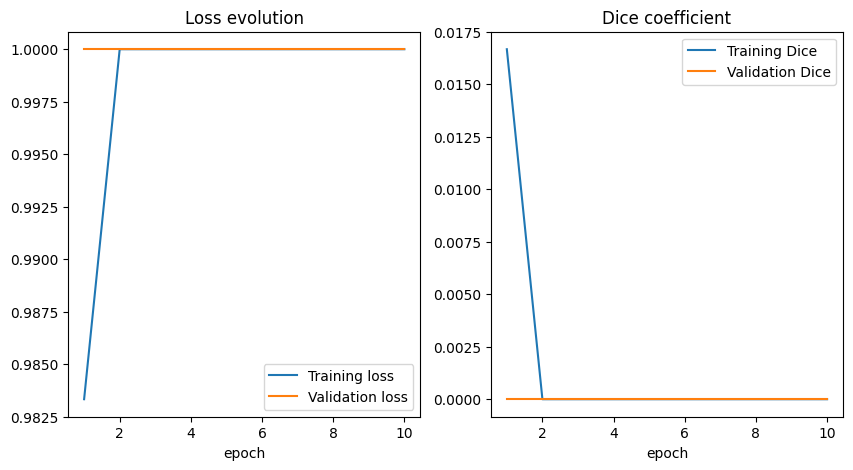

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

epochs = range(1, n_epochs + 1)
# Plot the loss curve in the first axis.
train_loss = history.history["loss"]
val_loss = history.history["val_loss"]

axs[0].plot(epochs, train_loss, label="Training loss")
axs[0].plot(epochs, val_loss, label="Validation loss")
axs[0].set_title("Loss evolution")

# Plot the Dice coefficient in the second axis.
train_dice = history.history["dice_coefficient"]
val_dice = history.history["val_dice_coefficient"]

axs[1].plot(epochs, train_dice, label="Training Dice")
axs[1].plot(epochs, val_dice, label="Validation Dice")
axs[1].set_title("Dice coefficient")

for ax in axs:
  ax.legend()
  ax.set_xlabel("epoch")

In [ ]:
test_loss, test_dice = model.evaluate(test_ds)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test  Dice: {test_dice:.4f}")

4/4 [==============================] - 265s 4s/step - loss: 1.0000 - dice_coefficient: 9.9880e-11
Test Loss: 1.0000
Test  Dice: 0.0000


In [ ]:
for test_batch in test_ds.take(1):
  test_vol = test_batch[0].numpy()[0, ...]
  ground_truth = np.squeeze(test_batch[1].numpy()[0, ...])

  prediction = model.predict(test_batch[0])
  pred_vol = np.squeeze(prediction[0, ...])

  print(test_vol.shape, test_vol.max(), test_vol.min())
  print(ground_truth.shape, np.unique(ground_truth))
  print(pred_vol.shape, np.unique(pred_vol))

  print(dice_coefficient(pred_vol, ground_truth))

1/1 [==============================] - 1s 506ms/step
(64, 64, 64) 1.0 -0.07816967
(64, 64, 64) [0. 1.]
(64, 64, 64) [0.]
tf.Tensor(3.1486147e-10, shape=(), dtype=float32)


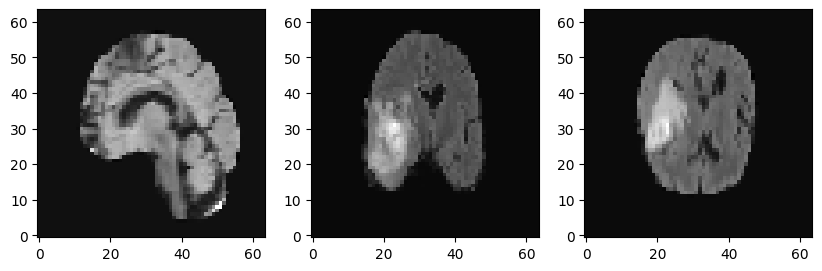

In [ ]:
_, axs = plt.subplots(1, 3, figsize=(10, 15))
axs[0].imshow(test_vol[32, ...].T, cmap="gray", origin="lower")
axs[1].imshow(test_vol[:, 32, :].T, cmap="gray", origin="lower")
axs[2].imshow(test_vol[..., 32].T, cmap="gray", origin="lower")

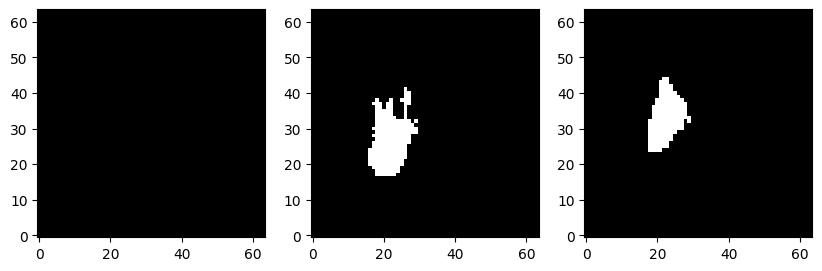

In [ ]:
_, axs = plt.subplots(1, 3, figsize=(10, 15))
axs[0].imshow(ground_truth[32, ...].T, cmap="gray", origin="lower")
axs[1].imshow(ground_truth[:, 32, :].T, cmap="gray", origin="lower")
axs[2].imshow(ground_truth[..., 32].T, cmap="gray", origin="lower")

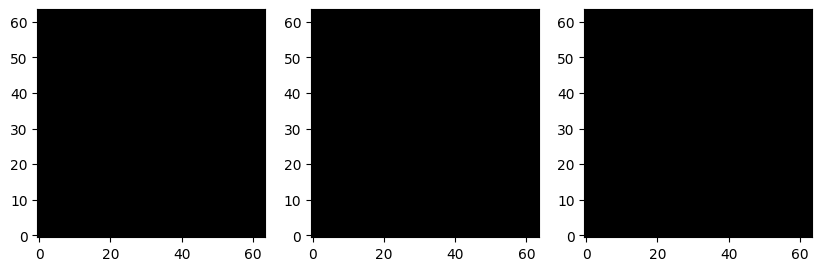

In [ ]:
_, axs = plt.subplots(1, 3, figsize=(10, 15))
axs[0].imshow(pred_vol[32, ...].T, cmap="gray", origin="lower")
axs[1].imshow(pred_vol[:, 32, :].T, cmap="gray", origin="lower")
axs[2].imshow(pred_vol[..., 32].T, cmap="gray", origin="lower")